<a href="https://colab.research.google.com/github/VIVEK-JADHAV/MovieRecommendation/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing libraries

import pandas as pd
import numpy as np
import os
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import csr_matrix,coo_matrix

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Loading the data

os.mkdir('/content/data')
os.chdir('/content/data')
print(os.getcwd())

!unzip '/content/drive/MyDrive/CaseStudies/RecommendationSystem/archive.zip'

/content/data
Archive:  /content/drive/MyDrive/CaseStudies/RecommendationSystem/archive.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


In [ ]:
movies_df=pd.read_csv('/content/data/movies_metadata.csv')
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

The required columns are genres,vote_average,vote_count,title

In [ ]:
#Keeping only the required columns

movies=movies_df[['title','genres','vote_average','vote_count','original_language','id']]
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              45460 non-null  object 
 1   genres             45466 non-null  object 
 2   vote_average       45460 non-null  float64
 3   vote_count         45460 non-null  float64
 4   original_language  45455 non-null  object 
 5   id                 45466 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.1+ MB


In [ ]:
#Null values
movies.isnull().sum()

title                 6
genres                0
vote_average          6
vote_count            6
original_language    11
id                    0
dtype: int64

In [ ]:
#Rows with null values
movies[movies.isnull().any(axis=1)==True]

,title,genres,vote_average,vote_count,original_language,id
19574,Shadowing the Third Man,"[{'id': 99, 'name': 'Documentary'}]",0.0,0.0,NaN,283101
19729,NaN,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,NaN,en,82663
19730,NaN,"[{'name': 'Carousel Productions', 'id': 11176}...",NaN,NaN,104.0,1997-08-20
21602,Unfinished Sky,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",6.4,8.0,NaN,103902
22832,13 Fighting Men,"[{'id': 10752, 'name': 'War'}, {'id': 37, 'nam...",0.0,0.0,NaN,359195
29502,NaN,"[{'id': 16, 'name': 'Animation'}, {'id': 878, ...",NaN,NaN,ja,122662
29503,NaN,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...",NaN,NaN,68.0,2012-09-29
32141,Lambchops,"[{'id': 35, 'name': 'Comedy'}]",6.5,2.0,NaN,147050
35586,NaN,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 28,...",NaN,NaN,en,249260
35587,NaN,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...",NaN,NaN,82.0,2014-01-01


In [ ]:
#Dropping Nan values
movies.dropna(inplace=True)
movies.isnull().sum()

title                0
genres               0
vote_average         0
vote_count           0
original_language    0
id                   0
dtype: int64

In [ ]:
#Transforming genre column with first occuring value
# Empty generes are replaced by Drama as it is most occuring value
def transformGenere(genre):
  lst=[]
  for i in genre:    
    if i['name']:
      lst.append(i['name'])
  return lst if len(lst)>0 else ["Drama"]
movies['genres']=movies['genres'].apply(literal_eval).apply(transformGenere)   #literal_eval removes quotes around list
movies.head()


,title,genres,vote_average,vote_count,original_language,id
0,Toy Story,"[Animation, Comedy, Family]",7.7,5415.0,en,862
1,Jumanji,"[Adventure, Fantasy, Family]",6.9,2413.0,en,8844
2,Grumpier Old Men,"[Romance, Comedy]",6.5,92.0,en,15602
3,Waiting to Exhale,"[Comedy, Drama, Romance]",6.1,34.0,en,31357
4,Father of the Bride Part II,[Comedy],5.7,173.0,en,11862


### Data Formulation

In [ ]:
#Changing the datatype of id to int
movies['id']=movies['id'].apply(pd.to_numeric)
movies['id'].dtype

dtype('int64')

In [ ]:
#Dataset containing movieId and imdbId
links=pd.read_csv('/content/data/links_small.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


In [ ]:
#Merging links and movies tables
temp_df=pd.merge(links,movies,left_on='movieId',right_on='id')
temp_df.head()

,movieId,imdbId,tmdbId,title,genres,vote_average,vote_count,original_language,id
0,2,113497,8844.0,Ariel,"[Drama, Crime]",7.1,44.0,fi,2
1,3,113228,15602.0,Shadows in Paradise,"[Drama, Comedy]",7.1,35.0,fi,3
2,5,113041,11862.0,Four Rooms,"[Crime, Comedy]",6.5,539.0,en,5
3,6,113277,949.0,Judgment Night,"[Action, Thriller, Crime]",6.4,79.0,en,6
4,11,112346,9087.0,Star Wars,"[Adventure, Action, Science Fiction]",8.1,6778.0,en,11


In [ ]:
#Loading ratings table

ratings_df=pd.read_csv('/content/data/ratings_small.csv')
print(ratings_df.shape)
ratings_df.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
#Merging ratings table with above merged table

ratings=pd.merge(ratings_df,temp_df,on='movieId')
ratings.drop(['imdbId','tmdbId','id'],axis=1,inplace=True)
ratings.head()

,userId,movieId,rating,timestamp,title,genres,vote_average,vote_count,original_language
0,1,1371,2.5,1260759135,Rocky III,[Drama],6.6,894.0,en
1,4,1371,4.0,949810302,Rocky III,[Drama],6.6,894.0,en
2,7,1371,3.0,851869160,Rocky III,[Drama],6.6,894.0,en
3,19,1371,4.0,855193404,Rocky III,[Drama],6.6,894.0,en
4,21,1371,3.0,853852263,Rocky III,[Drama],6.6,894.0,en


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44994 entries, 0 to 44993
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   userId             44994 non-null  int64  
 1   movieId            44994 non-null  int64  
 2   rating             44994 non-null  float64
 3   timestamp          44994 non-null  int64  
 4   title              44994 non-null  object 
 5   genres             44994 non-null  object 
 6   vote_average       44994 non-null  float64
 7   vote_count         44994 non-null  float64
 8   original_language  44994 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 3.4+ MB


In [ ]:
#Converting the timestamp to y-m-d format
ratings['timestamp']=pd.to_datetime(ratings['timestamp'])
ratings['timestamp']=ratings['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d'))
ratings['timestamp']=pd.to_datetime(ratings['timestamp'])

ratings.head()

,userId,movieId,rating,timestamp,title,genres,vote_average,vote_count,original_language
0,1,1371,2.5,1970-01-01,Rocky III,[Drama],6.6,894.0,en
1,4,1371,4.0,1970-01-01,Rocky III,[Drama],6.6,894.0,en
2,7,1371,3.0,1970-01-01,Rocky III,[Drama],6.6,894.0,en
3,19,1371,4.0,1970-01-01,Rocky III,[Drama],6.6,894.0,en
4,21,1371,3.0,1970-01-01,Rocky III,[Drama],6.6,894.0,en


In [ ]:
#This dataset has data of just one day
ratings['timestamp'].unique()

array(['1970-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
#Checking for duplicate rows
duplicate_rows=ratings.duplicated(['userId','movieId','rating']).sum()
print('There are {} duplicate rows'.format(duplicate_rows))

There are 5 duplicate rows


In [ ]:
#Dropping duplicate rows
ratings.drop_duplicates(['userId','movieId','rating'],inplace=True)
duplicate_rows=ratings.duplicated(['userId','movieId','rating']).sum()
print(duplicate_rows)

0


In [ ]:
#Toatal number of unique movies and users

unique_users=ratings['userId'].nunique()
print('Total number of unique users are',unique_users)

unique_movies=ratings['movieId'].nunique()
print('Total number of unique movies are',unique_movies)

Total number of unique users are 671
Total number of unique movies are 2830


### Exploratory Data Analysis

#### Analysis of Ratings Feature

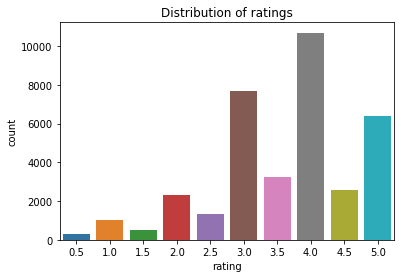

In [ ]:
#Distribution of ratings

ax=sns.countplot(train['rating'])
ax.set_title('Distribution of ratings')
plt.show()



In [ ]:
#Percentage of different ratings
train['rating'].value_counts()*100/train.shape[0]

4.0    29.696313
3.0    21.380345
5.0    17.759996
3.5     9.021700
4.5     7.076769
2.0     6.409936
2.5     3.698147
1.0     2.811814
1.5     1.364230
0.5     0.780751
Name: rating, dtype: float64

* Ratings range from 0.5 to 5 in the increments of 0.5
* Users have rated a large amount of movies with ratings 3 and 4 

#### Analysis of Users Feature

In [ ]:
#Number of Ratings given by different users

users=train.groupby(['userId'])['rating'].count()

users.head()

userId
1      6
2     58
3     25
4    114
5     53
Name: rating, dtype: int64

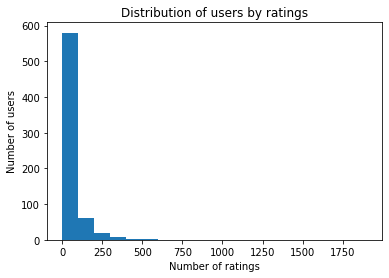

In [ ]:
#Distribution of users by ratings
plt.hist(users,range(0,2000,100))

plt.title('Distribution of users by ratings')

plt.xlabel('Number of ratings')
plt.ylabel('Number of users')

plt.show()

In [ ]:
users.describe()

count    671.000000
mean      53.637854
std       64.387829
min        2.000000
25%       17.000000
50%       31.000000
75%       65.000000
max      565.000000
Name: rating, dtype: float64

* Every user has rated minimum of 2 movies
* 50% of users have rated 31 or less number of movies
* Most  of the users have rated fewer movies
* There are users who have rated more than 200 movies.

#### Analysis of Movies Feature

In [ ]:
#Number of Ratings given to  different movies

movies=train.groupby(['movieId'])['rating'].count()

movies.head()

movieId
2     107
3      59
5      56
6     104
11     82
Name: rating, dtype: int64

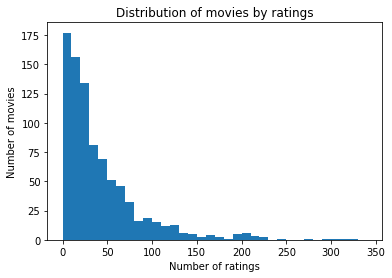

In [ ]:
#Distribution of users by ratings
plt.hist(movies,range(0,350,10))

plt.title('Distribution of movies by ratings')

plt.xlabel('Number of ratings')
plt.ylabel('Number of movies')

plt.show()

In [ ]:
movies.describe()

count    863.000000
mean      41.704519
std       45.911516
min        1.000000
25%       12.000000
50%       27.000000
75%       54.500000
max      324.000000
Name: rating, dtype: float64

* Every movie has been rated by atleast one user.
* 50% of movies have been rated 27 or less number of times
* Most  of the movies have fewer ratings.
* There are few movies which been rated more than 200 times.